# Код с [сайта](https://www.geeksforgeeks.org/implementation-of-bayesian-regression/)

Iteration 100/1000 - Loss: 26402.817811191082
Iteration 200/1000 - Loss: 868.8795000314713
Iteration 300/1000 - Loss: 375.8895353078842
Iteration 400/1000 - Loss: 410.9912316799164
Iteration 500/1000 - Loss: 1326.6758230924606
Iteration 600/1000 - Loss: 6281.595920860767
Iteration 700/1000 - Loss: 928.8973389863968
Iteration 800/1000 - Loss: 162330.19546687603
Iteration 900/1000 - Loss: 803.6283965706825
Iteration 1000/1000 - Loss: 16296.750355422497
Estimated Slope: 0.632914662361145
Estimated Intercept: 0.6321612000465393
Estimated Sigma: 1.546432375907898


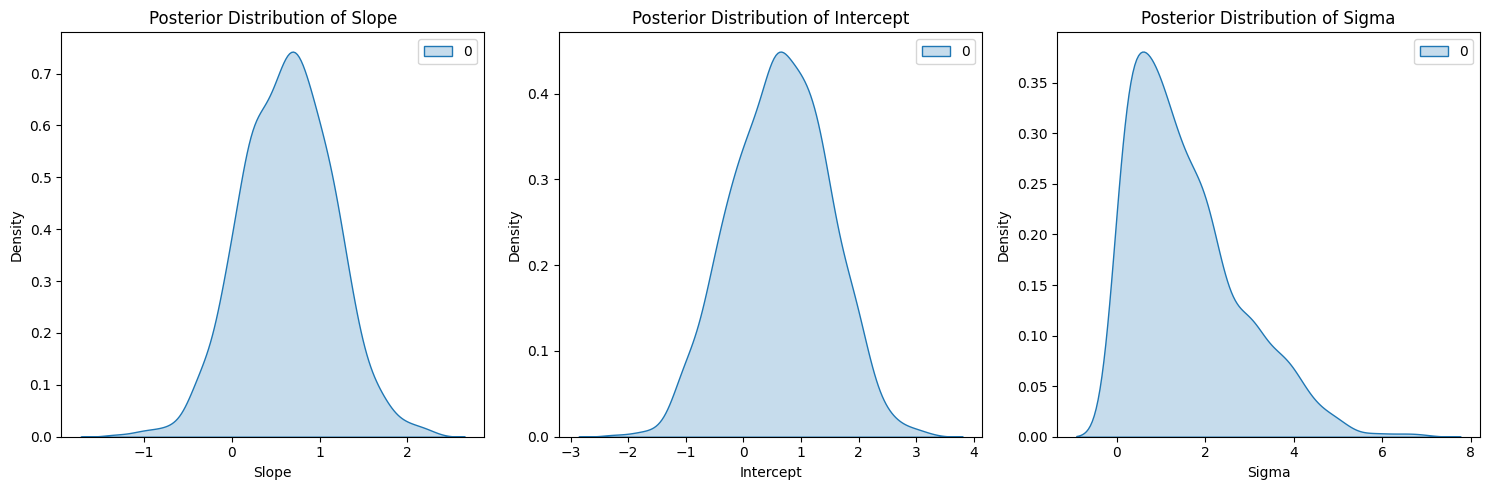

In [2]:
#Import the necessary libraries
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns


# Generate some sample data
torch.manual_seed(0)
X = torch.linspace(0, 10, 100)
true_slope = 2
true_intercept = 1
Y = true_intercept + true_slope * X + torch.randn(100)

# Define the Bayesian regression model
def model(X, Y):
	# Priors for the parameters
	slope = pyro.sample("slope", dist.Normal(0, 10))
	intercept = pyro.sample("intercept", dist.Normal(0, 10))
	sigma = pyro.sample("sigma", dist.HalfNormal(1))

	# Expected value of the outcome
	mu = intercept + slope * X

	# Likelihood (sampling distribution) of the observations
	with pyro.plate("data", len(X)):
		pyro.sample("obs", dist.Normal(mu, sigma), obs=Y)

# Run Bayesian inference using SVI (Stochastic Variational Inference)
def guide(X, Y):
	# Approximate posterior distributions for the parameters
	slope_loc = pyro.param("slope_loc", torch.tensor(0.0))
	slope_scale = pyro.param("slope_scale", torch.tensor(1.0),
							constraint=dist.constraints.positive)
	intercept_loc = pyro.param("intercept_loc", torch.tensor(0.0))
	intercept_scale = pyro.param("intercept_scale", torch.tensor(1.0),
								constraint=dist.constraints.positive)
	sigma_loc = pyro.param("sigma_loc", torch.tensor(1.0), 
						constraint=dist.constraints.positive)

	# Sample from the approximate posterior distributions
	slope = pyro.sample("slope", dist.Normal(slope_loc, slope_scale))
	intercept = pyro.sample("intercept", dist.Normal(intercept_loc, 
													intercept_scale))
	sigma = pyro.sample("sigma", dist.HalfNormal(sigma_loc))

# Initialize the SVI and optimizer
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

# Run the inference loop
num_iterations = 1000
for i in range(num_iterations):
	loss = svi.step(X, Y)
	if (i + 1) % 100 == 0:
		print(f"Iteration {i + 1}/{num_iterations} - Loss: {loss}")

# Obtain posterior samples using Predictive
predictive = Predictive(model, guide=guide, num_samples=1000)
posterior = predictive(X, Y)

# Extract the parameter samples
slope_samples = posterior["slope"]
intercept_samples = posterior["intercept"]
sigma_samples = posterior["sigma"]

# Compute the posterior means
slope_mean = slope_samples.mean()
intercept_mean = intercept_samples.mean()
sigma_mean = sigma_samples.mean()

# Print the estimated parameters
print("Estimated Slope:", slope_mean.item())
print("Estimated Intercept:", intercept_mean.item())
print("Estimated Sigma:", sigma_mean.item())


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the posterior distribution of the slope
sns.kdeplot(slope_samples, fill=True, ax=axs[0])
axs[0].set_title("Posterior Distribution of Slope")
axs[0].set_xlabel("Slope")
axs[0].set_ylabel("Density")

# Plot the posterior distribution of the intercept
sns.kdeplot(intercept_samples, fill=True, ax=axs[1])
axs[1].set_title("Posterior Distribution of Intercept")
axs[1].set_xlabel("Intercept")
axs[1].set_ylabel("Density")

# Plot the posterior distribution of sigma
sns.kdeplot(sigma_samples, fill=True, ax=axs[2])
axs[2].set_title("Posterior Distribution of Sigma")
axs[2].set_xlabel("Sigma")
axs[2].set_ylabel("Density")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

# Код из [статейки на хабре](https://habr.com/ru/articles/853560/)

In [3]:
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Создание синтетических данных
X, y = make_regression(n_samples=100, n_features=2, noise=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Инициализация байесовской линейной регрессии
model = BayesianRidge()
model.fit(X_train, y_train)

# Предсказание и оценка модели
y_pred = model.predict(X_test)
print("Среднеквадратичная ошибка:", mean_squared_error(y_test, y_pred))
print("Средние апостериорные параметры:", model.coef_)
print("Дисперсии параметров:", model.sigma_)

Среднеквадратичная ошибка: 86.09616355414465
Средние апостериорные параметры: [47.27667351 14.12956674]
Дисперсии параметров: [[1.20620695 0.0305637 ]
 [0.0305637  1.0579467 ]]


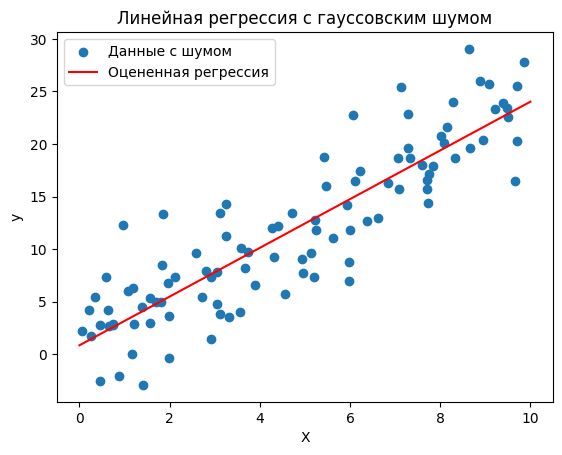

Оцененный коэффициент beta: [0.86038463 2.31609071]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Генерация данных
np.random.seed(42)
n = 100  # Число точек
X = np.random.rand(n, 1) * 10  # Признаки от 0 до 10
true_beta = np.array([2.5])  # Истинный коэффициент
sigma = 1  # Стандартное отклонение шума
epsilon = np.random.normal(0, 4, size=(n, 1))  # Гауссовский шум

# Генерируем наблюдаемые y
y = (X @ true_beta).ravel() + epsilon.ravel()

# Оценка коэффициента методом максимального правдоподобия (МНК)
X_b = np.c_[np.ones((n, 1)), X]  # Добавляем столбец единиц для свободного члена
beta_hat = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y  # (X^T X)^-1 X^T y

# Визуализация
plt.scatter(X, y, label="Данные с шумом")
X_range = np.linspace(0, 10, 100).reshape(-1, 1)
X_range_b = np.c_[np.ones((100, 1)), X_range]
y_pred = X_range_b @ beta_hat

plt.plot(X_range, y_pred, color='red', label="Оцененная регрессия")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Линейная регрессия с гауссовским шумом")
plt.show()

# Вывод оцененных параметров
print(f"Оцененный коэффициент beta: {beta_hat.ravel()}")


# Моя попытка